In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from envs.mimic import MIMICEnv
from rl_policies import D3QNAgent, CQLAgent

import warnings
warnings.filterwarnings('ignore')

In [39]:
# tools for training, evaluating, visualizing our policies

def train_policy(model, env, n_episodes=50_000, update_freq=1000, target_network=False, model_name='model'):
    """
    Training loop to learn a Q-function.
    """
    rewards, lengths, q_vals = [], [], []

    for i in tqdm(range(n_episodes)):
        state, _ = env.reset()
        done = False
        total_reward, episode_length = 0, 0

        while not done:
            action = model.select_action(torch.from_numpy(state))
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            # store tuple in memory and do one training step
            model.learn(state, action, reward, next_state, done)
            # update for next timestep
            state = next_state
            total_reward += reward
            episode_length += 1

        if i % update_freq == 0:
            # for the last episode, log the cumulative reward and episode length
            rewards.append(total_reward)
            lengths.append(episode_length)
            
            # see if we're learning a Q-function
            action_values = model.get_action_values(torch.from_numpy(state))
            q_vals.append(action_values.max())

            # update target network weights
            if target_network:
                self.hard_update()

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))

    axs[0].plot(pd.Series(rewards))
    axs[0].set_title(f'{model_name} reward per episode')
    
    axs[1].plot(pd.Series(lengths))
    axs[1].set_title(f'{model_name} episode lengths')
    
    axs[2].plot(pd.Series(q_vals))
    axs[2].set_title(f'{model_name} q function during training')


def get_action_tuple(idx):
    """
    Given a action ID in the range [0, 24], convert it to the corresponding
    (iv, vaso) tuple. Note: ID = 5*iv + vaso
    """
    vaso = idx % 5
    iv = int((idx - vaso) / 5)
    return (iv, vaso)


def eval_policy(model, env, n_episodes=1000, model_name='model'):
    """
    Evaluate our learned policy, to see what Q-function we're learning.
    """
    q_vals = []
    action_log = np.zeros((5,5))
    
    for i in tqdm(range(n_episodes)):
        state, _ = env.reset()
        done = False
        episode_q_vals = []
        while not done:
            action = model.select_action(torch.from_numpy(state), eps=0.0) # greedy (no exploration)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = next_state
            # log action
            action_tuple = get_action_tuple(action)
            action_log[action_tuple] += 1

            if i % 100 == 0:
                # log the max q value at each timestep
                action_values = model.get_action_values(torch.from_numpy(state))
                episode_q_vals.append(action_values.max())

        if i % 100 == 0:
            # get the average q value over the episode
            avg_q_val = np.mean(episode_q_vals)
            q_vals.append(avg_q_val)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # visualize q function
    axs[0].plot(pd.Series(q_vals))
    axs[0].set_title('Q function during eval')
    print(q_vals)

    # visualize action selection
    policy_heatmap(action_log, model_name, axs[1])

    plt.show()

            

def policy_heatmap(action_array, model_name, ax):
    """
    Visualize the actions selected by a policy, as recorded in the environment's action_log.
    """
        
    sns.heatmap(action_array, cmap='crest', annot=True, ax=ax)

    ax.set_title(f'{model_name} policy')
    ax.set_xlabel('vasopressor bin')
    ax.set_ylabel('iv bin')
    ax.invert_yaxis()
    ax.grid(which='minor', color='b', linestyle='-', linewidth=1)


100%|████████████████████████████████████| 50000/50000 [07:33<00:00, 110.29it/s]


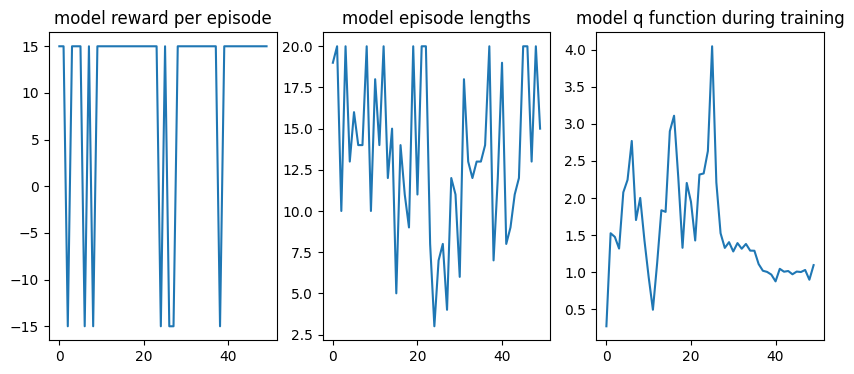

In [51]:
### Dueling Double Deep Q Networks ###

env = MIMICEnv()
d3qn_agent = D3QNAgent(env.obs_dim, env.action_dim)

train_policy(d3qn_agent, env)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1079.74it/s]


[0.9474386, 0.9474386, 0.94743836, 0.9474385, 0.94743836, 0.9474384, 0.94743854, 0.9474386, 0.9474384, 0.9474386]


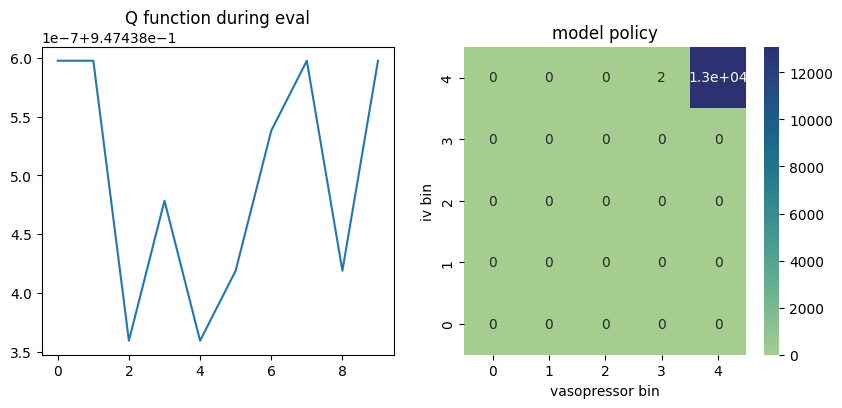

In [52]:
eval_policy(d3qn_agent, env)

# TODO goofy ah action selection. wonder why that's happening.

100%|█████████████████████████████████████| 50000/50000 [11:44<00:00, 70.95it/s]


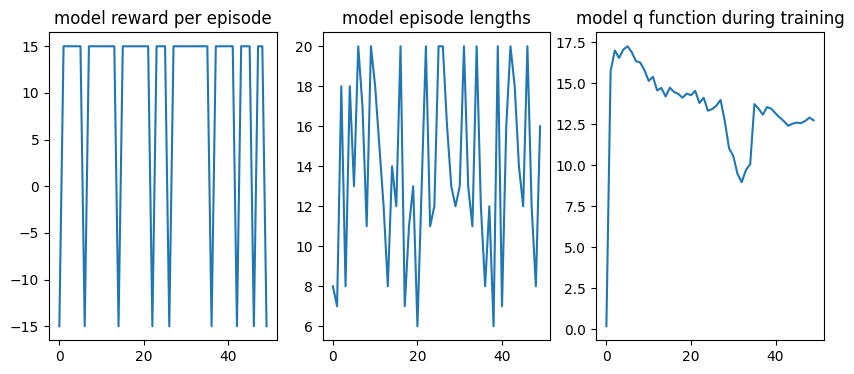

In [53]:
### Conservative Q-Learning (CQL) ###

cql_agent = CQLAgent(env.obs_dim, env.action_dim)
train_policy(cql_agent, env)

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 951.81it/s]


[14.056284, 12.610693, 13.614603, 12.0654955, 13.656755, 13.060287, 9.474963, 13.017942, 12.893932, 13.784612]


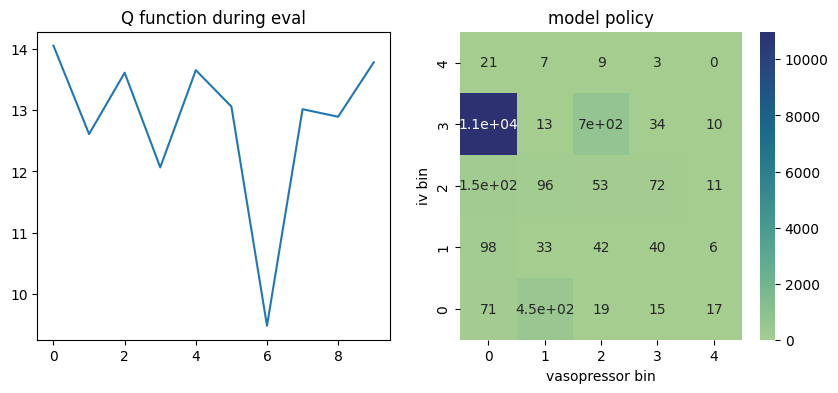

In [54]:
eval_policy(cql_agent, env)

In [67]:
### Clinician Imitation (FQE) ###

clinician = FQEAgent(env.obs_dim, env.action_dim)
train_policy(clinician, env)

100%|██████████████████████████████████████| 5000/5000 [00:44<00:00, 111.45it/s]


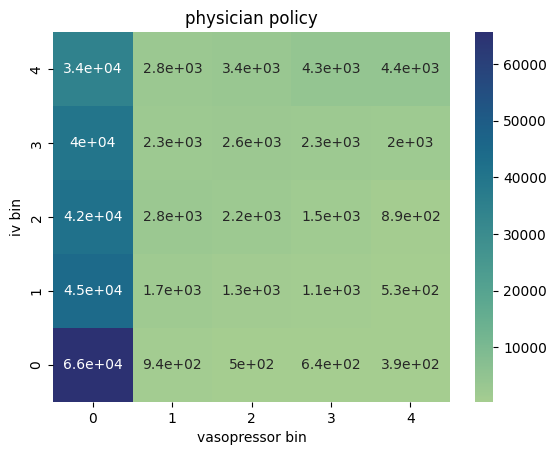

In [40]:
### Actual physician policy recorded in the data ###

df = pd.read_csv('data/sepsis_df.csv')

def get_action_log(df):
    action_log = np.zeros((5,5))
    for iv, vaso in zip(df['iv_bin'], df['vaso_bin']):
        action_log[(iv, vaso)] += 1
    return action_log

all_action_log = get_action_log(df)

fig, ax = plt.subplots()
policy_heatmap(all_action_log, 'physician', ax)

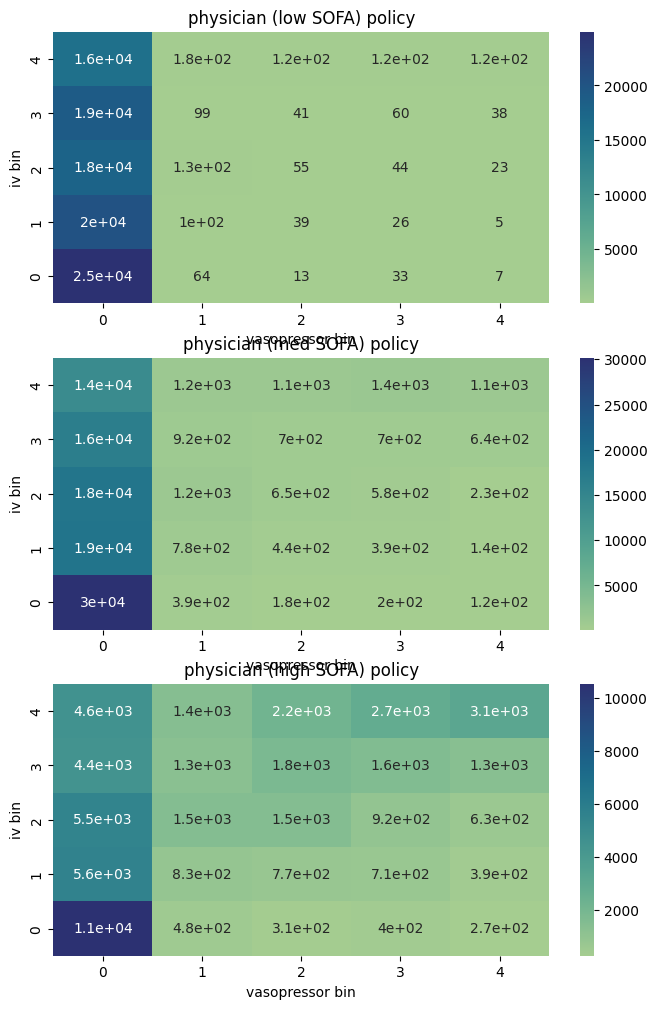

In [47]:
low_sofa_action_log = get_action_log(df[df['SOFA'] <= 4])
med_sofa_action_log = get_action_log(df[(df['SOFA'] > 4) & (df['SOFA'] <= 8)])
high_sofa_action_log = get_action_log(df[df['SOFA'] > 8])

fig, axs = plt.subplots(3, 1, figsize=(8,12))
policy_heatmap(low_sofa_action_log, 'physician (low SOFA)', axs[0])
policy_heatmap(med_sofa_action_log, 'physician (med SOFA)', axs[1])
policy_heatmap(high_sofa_action_log, 'physician (high SOFA)', axs[2])

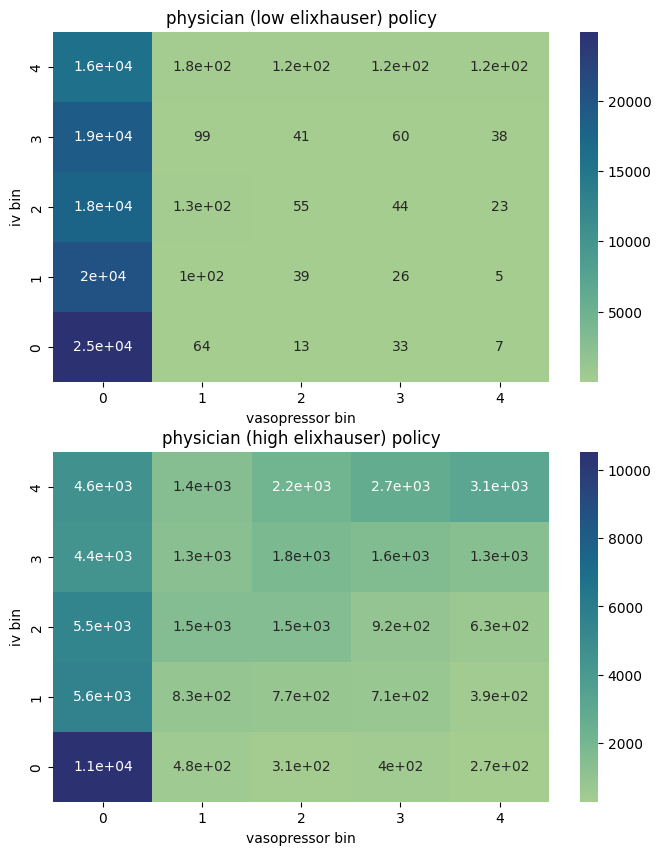

In [44]:
low_elixhauser_action_log = get_action_log(df[df['elixhauser'] < df['elixhauser'].mean()])
high_elixhauser_action_log = get_action_log(df[df['SOFA'] >= df['elixhauser'].mean()])

fig, axs = plt.subplots(2, 1, figsize=(8,10))
policy_heatmap(low_sofa_action_log, 'physician (low elixhauser)', axs[0])
policy_heatmap(high_sofa_action_log, 'physician (high elixhauser)', axs[1])